### Install and import libraries

In [58]:
# If needed, install libraries (run once in your environment)
# !pip install lifelines scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import CoxPHFitter

from sklearn.model_selection import KFold
from lifelines.utils import k_fold_cross_validation


### Load dataset

In [59]:
# Load the Telco Customer Churn dataset from the project folder
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

df.head()


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

###  Quick data overview

In [60]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Shape: (7043, 21)

Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecur

### Basic cleaning: handle TotalCharges as numeric and drop missing

In [61]:
# TotalCharges sometimes comes as object; coerce to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop rows with missing TotalCharges after coercion
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

print("Shape after dropping rows with missing TotalCharges:", df.shape)


Shape after dropping rows with missing TotalCharges: (7032, 21)


### Define survival variables (time and event)

In [62]:
# time: tenure (months)
time_col = "tenure"

# event: churn (Yes=1, No=0)
df["Churn_event"] = df["Churn"].map({"Yes": 1, "No": 0})

df[["tenure", "Churn", "Churn_event"]].head()


tenure Churn  Churn_event
0       1    No            0
1      34    No            0
2       2   Yes            1
3      45    No            0
4       2   Yes            1

### Basic exploratory plots of main variables

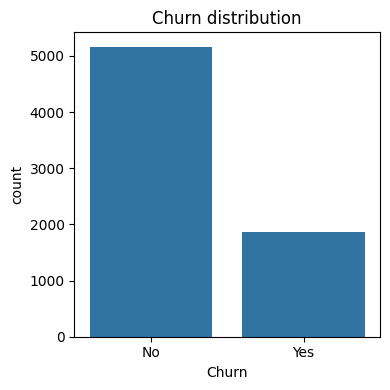

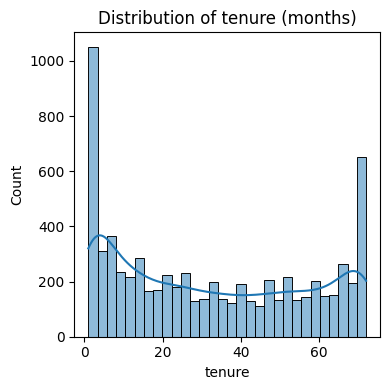

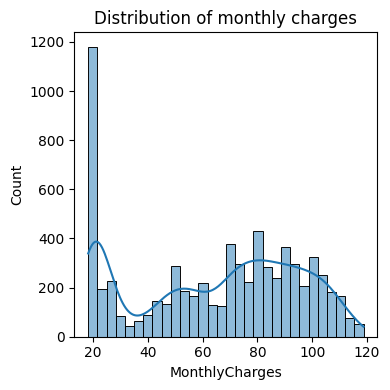

In [63]:
# 1) Churn distribution
plt.figure(figsize=(4, 4))
sns.countplot(data=df, x="Churn")
plt.title("Churn distribution")
plt.tight_layout()
plt.savefig("churn_distribution.png", dpi=300)   # saved as a separate file
plt.show()

# 2) Tenure distribution
plt.figure(figsize=(4, 4))
sns.histplot(df["tenure"], bins=30, kde=True)
plt.title("Distribution of tenure (months)")
plt.tight_layout()
plt.savefig("tenure_distribution.png", dpi=300)
plt.show()

# 3) Monthly charges distribution
plt.figure(figsize=(4, 4))
sns.histplot(df["MonthlyCharges"], bins=30, kde=True)
plt.title("Distribution of monthly charges")
plt.tight_layout()
plt.savefig("monthly_charges_distribution.png", dpi=300)
plt.show()


### Kaplan–Meier curves by Contract type

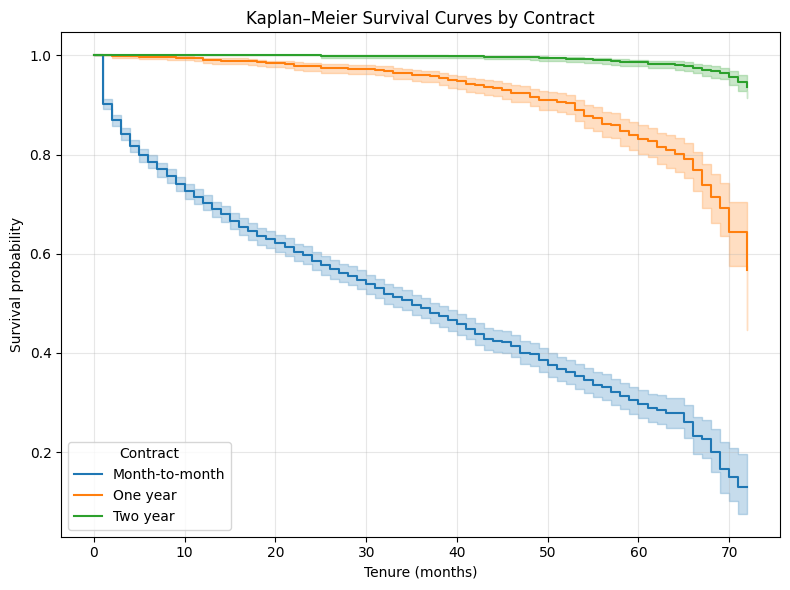

In [64]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for name, grouped_df in df.groupby("Contract"):
    kmf.fit(
        durations=grouped_df[time_col],
        event_observed=grouped_df["Churn_event"],
        label=name
    )
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Survival Curves by Contract")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival probability")
plt.legend(title="Contract")
plt.grid(True, alpha=0.3)

# Save figure (choose your name and format)
plt.tight_layout()
plt.savefig("km_survival_by_contract.png", dpi=300)  # or .pdf, .svg, etc.

plt.show()


###  Global log-rank test for Contract groups

In [65]:
# Global log-rank test comparing survival across all contract types
results_contract = multivariate_logrank_test(
    event_durations=df[time_col],
    groups=df["Contract"],
    event_observed=df["Churn_event"]
)

print("Global log-rank test for Contract:")
print(results_contract.summary)


Global log-rank test for Contract:
   test_statistic    p  -log2(p)
0     2352.872538  0.0       inf


### Pairwise log-rank tests for Contract groups

In [66]:
contract_types = df["Contract"].unique()
pairwise_results = []

for i in range(len(contract_types)):
    for j in range(i + 1, len(contract_types)):
        g1 = contract_types[i]
        g2 = contract_types[j]
        df1 = df[df["Contract"] == g1]
        df2 = df[df["Contract"] == g2]
        
        res = logrank_test(
            df1[time_col], df2[time_col],
            event_observed_A=df1["Churn_event"],
            event_observed_B=df2["Churn_event"]
        )
        pairwise_results.append({
            "Group 1": g1,
            "Group 2": g2,
            "Test statistic": res.test_statistic,
            "p-value": res.p_value
        })

pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df


Group 1   Group 2  Test statistic        p-value
0  Month-to-month  One year      926.064559  2.117327e-203
1  Month-to-month  Two year     1550.510307   0.000000e+00
2        One year  Two year      256.217767   1.145448e-57

### Kaplan–Meier curves by PaymentMethod

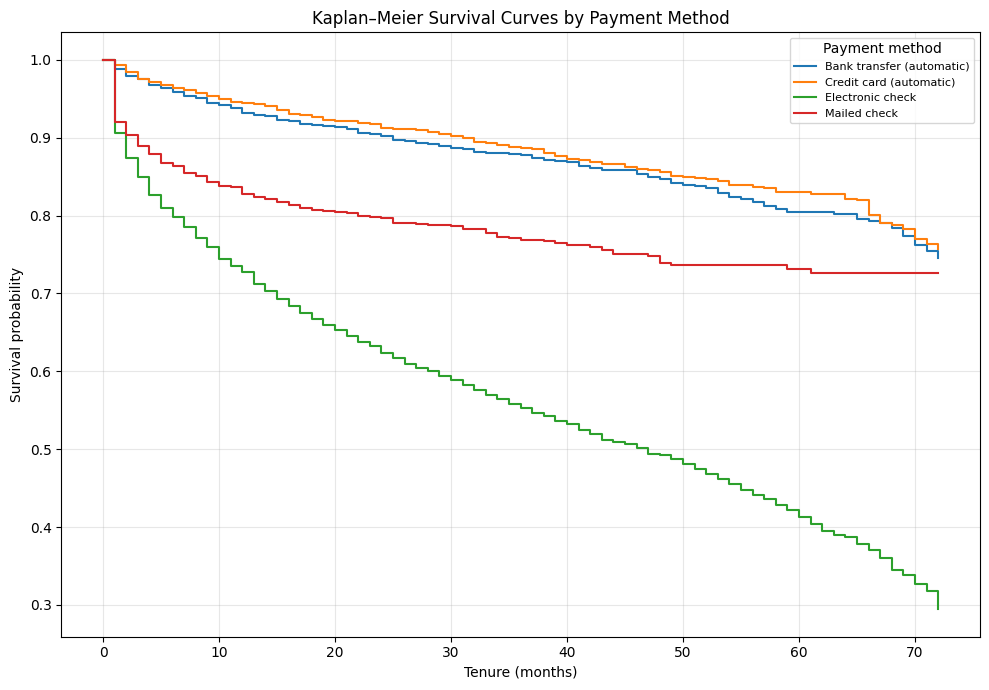

In [67]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))

for name, grouped_df in df.groupby("PaymentMethod"):
    kmf.fit(
        durations=grouped_df[time_col],
        event_observed=grouped_df["Churn_event"],
        label=name
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves by Payment Method")
plt.xlabel("Tenure (months)")
plt.ylabel("Survival probability")
plt.legend(title="Payment method", fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("km_survival_by_payment_method.png", dpi=300)  # choose name/format

plt.show()


### Select variables for Cox models

In [68]:
# Choose covariates: demographics + services + account info
categorical_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# One-hot encode categorical variables (drop first to avoid collinearity)
df_encoded = pd.get_dummies(df,
                            columns=categorical_cols,
                            drop_first=True)

df_encoded.head()


customerID  tenure  MonthlyCharges  TotalCharges Churn  Churn_event  \
0  7590-VHVEG       1           29.85         29.85    No            0   
1  5575-GNVDE      34           56.95       1889.50    No            0   
2  3668-QPYBK       2           53.85        108.15   Yes            1   
3  7795-CFOCW      45           42.30       1840.75    No            0   
4  9237-HQITU       2           70.70        151.65   Yes            1   

   gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  ...  \
0        False            False         True           False  ...   
1         True            False        False           False  ...   
2         True            False        False           False  ...   
3         True            False        False           False  ...   
4        False            False        False           False  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            False   
1                            False            False   
2                            False            False   
3                            False            False   
4                            False            False   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                False                False   
1                                False                False   
2                                False                False   
3                                False                False   
4                                False                False   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0              False              False                  True   
1               True              False                 False   
2              False              False                  True   
3               True              False                 False   
4              False              False                  True   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  
0                       False  
1                        True  
2                        True  
3                       False  
4                       False  

[5 rows x 33 columns]

### Define data for Cox model and standardize numeric covariates (except time)

In [69]:
# Keep survival columns and encoded covariates
cols_to_use = [time_col, "Churn_event"] + [c for c in df_encoded.columns
                                           if c not in [time_col, "Churn", "Churn_event", "customerID"]]

cox_df = df_encoded[cols_to_use].copy()

# Standardize selected numeric covariates (not the time column)
for col in ["MonthlyCharges", "TotalCharges"]:
    mean = cox_df[col].mean()
    std = cox_df[col].std()
    cox_df[col] = (cox_df[col] - mean) / std

cox_df.head()


tenure  Churn_event  MonthlyCharges  TotalCharges  gender_Male  \
0       1            0       -1.161611     -0.994123        False   
1      34            0       -0.260859     -0.173727         True   
2       2            1       -0.363897     -0.959581         True   
3      45            0       -0.747797     -0.195234         True   
4       2            1        0.196164     -0.940391        False   

   SeniorCitizen_1  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0            False         True           False             False   
1            False        False           False              True   
2            False        False           False              True   
3            False        False           False             False   
4            False        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...                            False   
1                           False  ...                            False   
2                           False  ...                            False   
3                            True  ...                            False   
4                           False  ...                            False   

   StreamingTV_Yes  StreamingMovies_No internet service  StreamingMovies_Yes  \
0            False                                False                False   
1            False                                False                False   
2            False                                False                False   
3            False                                False                False   
4            False                                False                False   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0              False              False                  True   
1               True              False                 False   
2              False              False                  True   
3               True              False                 False   
4              False              False                  True   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  
0                       False  
1                        True  
2                        True  
3                       False  
4                       False  

[5 rows x 31 columns]

### Fit standard Cox proportional hazards model

In [70]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(cox_df, duration_col=time_col, event_col="Churn_event")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -13045.80
         time fit was run = 2026-02-07 12:21:37 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                         0.24      1.27      0.10            0.03            0.44                1.03                1.56
TotalCharges                          -2.41      0.09      0.06           -2.54           -2.29                0.08                0.10
gender_Male                           -0.04      0.96      0.05           -0.13            0.05                0.88                1.05
SeniorCitizen_1                        0.02      1.02      0.06           -0.09            0.13                0.92                1.14
Partner_Yes                           -0.24      0.79      0.05           -0.34           -0.13                0.71                0.88
Dependents_Yes                        -0.11      0.90      0.07           -0.24            0.02                0.79                1.02
PhoneService_Yes                       0.26      1.30      0.29           -0.31            0.84                0.73                2.31
MultipleLines_No phone service        -0.26      0.77      0.29           -0.84            0.31                0.43                1.36
MultipleLines_Yes                     -0.02      0.98      0.05           -0.12            0.09                0.89                1.09
InternetService_Fiber optic            0.85      2.35      0.11            0.64            1.06                1.91                2.89
InternetService_No                    -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
OnlineSecurity_No internet service    -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
OnlineSecurity_Yes                    -0.32      0.72      0.07           -0.46           -0.19                0.63                0.82
OnlineBackup_No internet service      -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
OnlineBackup_Yes                      -0.16      0.85      0.06           -0.27           -0.05                0.77                0.95
DeviceProtection_No internet service  -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
DeviceProtection_Yes                  -0.00      1.00      0.06           -0.11            0.11                0.89                1.11
TechSupport_No internet service       -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
TechSupport_Yes                       -0.19      0.83      0.07           -0.32           -0.06                0.73                0.94
StreamingTV_No internet service       -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
StreamingTV_Yes                        0.21      1.24      0.06            0.09            0.33                1.09                1.39
StreamingMovies_No internet service   -0.28      0.75      0.27           -0.81            0.25                0.44                1.28
StreamingMovies_Yes                    0.20      1.22      0.06            0.08            0.32                1.08                1.38
Contract_One year                     -1.04      0.35      0.09           -1.21           -0.87                0.30                0.42
Contract_Two year           

### Visualise hazard ratios (forest plot)

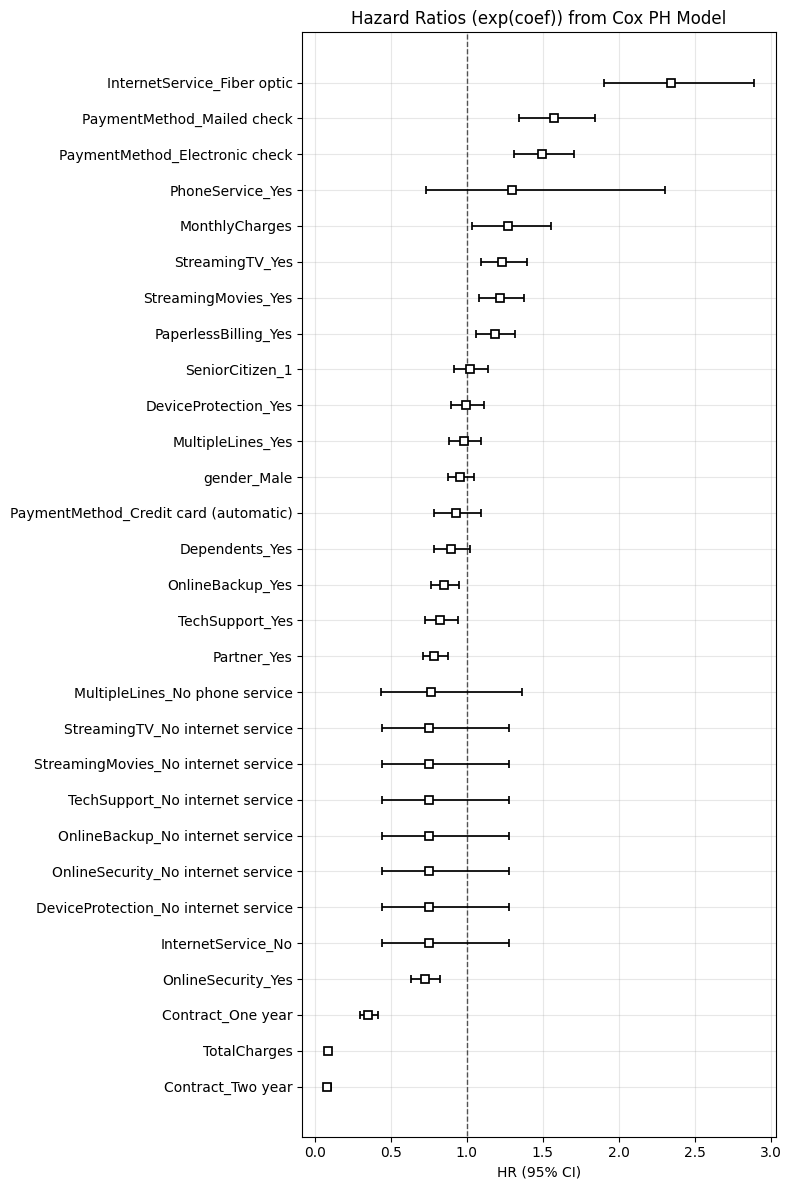

In [71]:
plt.figure(figsize=(8, 12))        # set figure size here
ax = cph.plot(hazard_ratios=True)  # no figsize argument

plt.title("Hazard Ratios (exp(coef)) from Cox PH Model")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure to a file
plt.savefig("cox_hazard_ratios.png", dpi=300)  # or .pdf / .svg etc.

plt.show()


### Check proportional hazards assumption


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Partner_Yes' failed the non-proportional test: p-value is 0.0337.

   Advice: with so few unique values (only 2), you can include `strata=['Partner_Yes', ...]` in 

c:\Users\Nawshin Nasir\AppData\Local\Programs\Python\Python312\Lib\site-packages\lifelines\fitters\mixins.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()



9. Variable 'StreamingTV_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['StreamingTV_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


10. Variable 'StreamingMovies_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['StreamingMovies_Yes', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


11. Variable 'Contract_One year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


12. Variable 'Contract_Two year' failed the

[[<Axes: xlabel='rank-transformed time\n(p=0.0638)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0828)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7441)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9684)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6911)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4619)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2959)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0337)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1100)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7696)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7836)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4417)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4696)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4417)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4696)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0014)'>],
 [<Axes: xlabel='rank-transformed tim

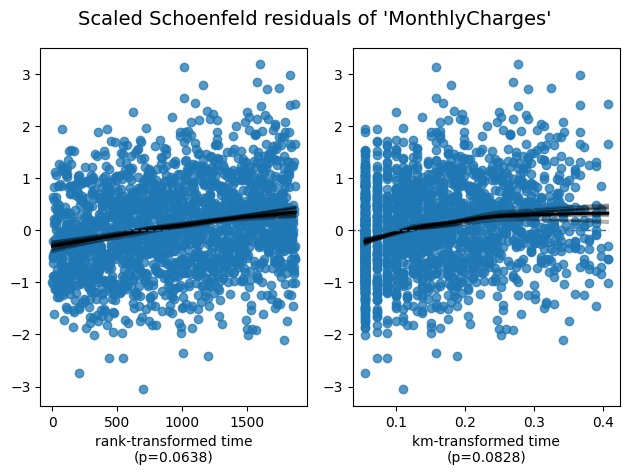

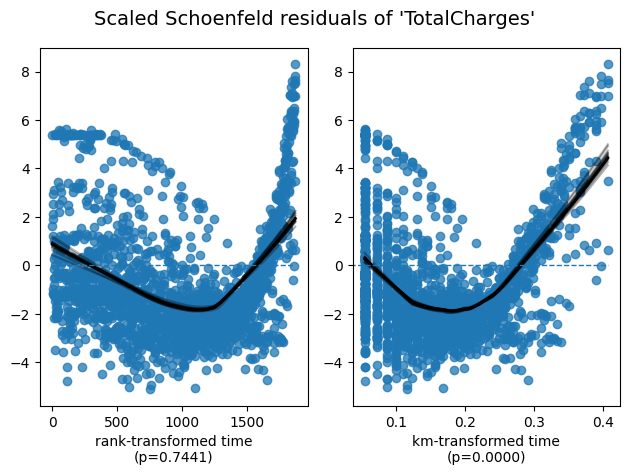

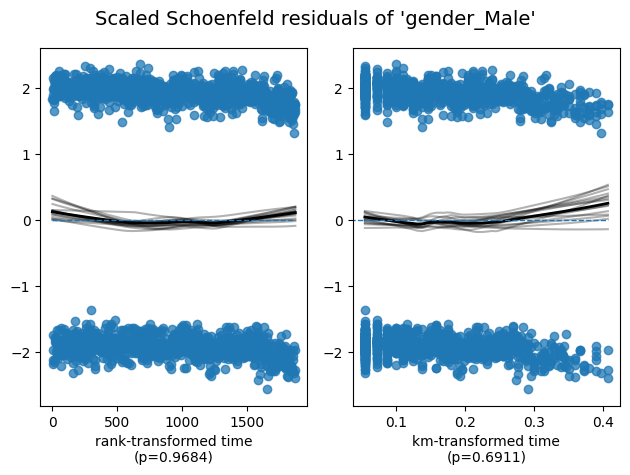

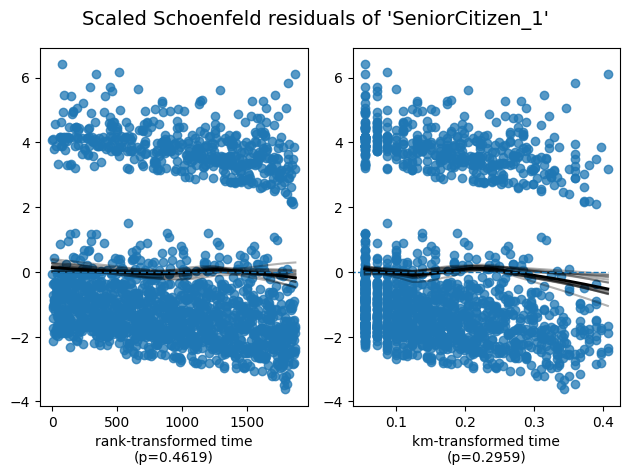

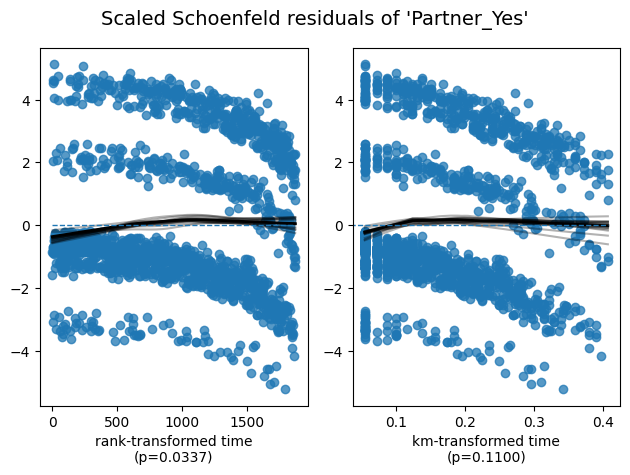

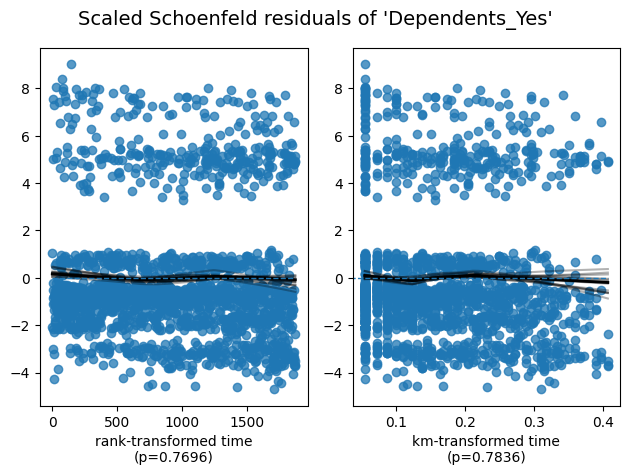

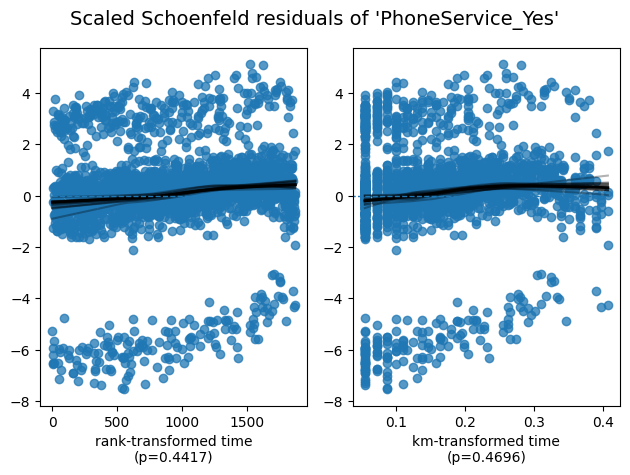

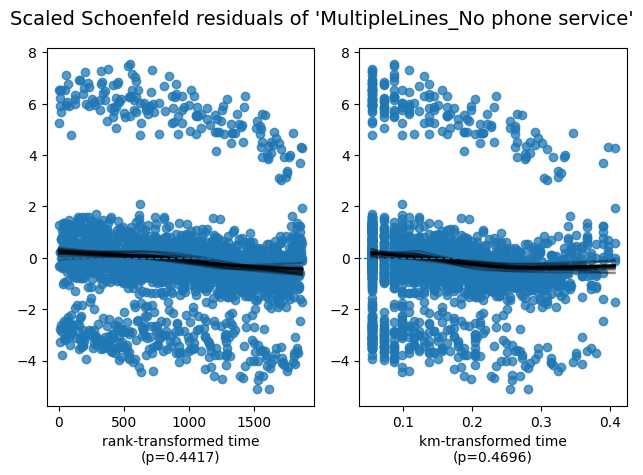

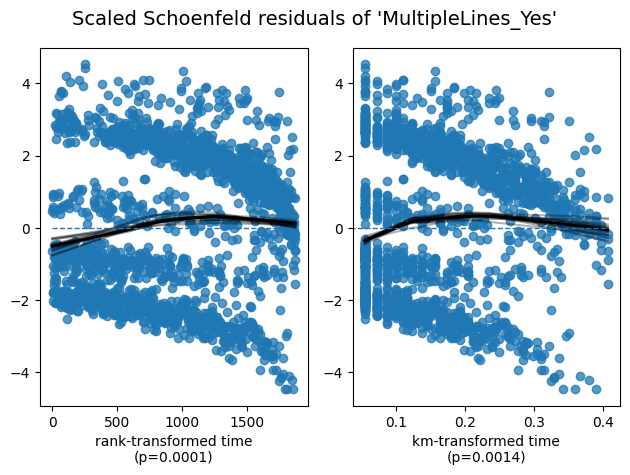

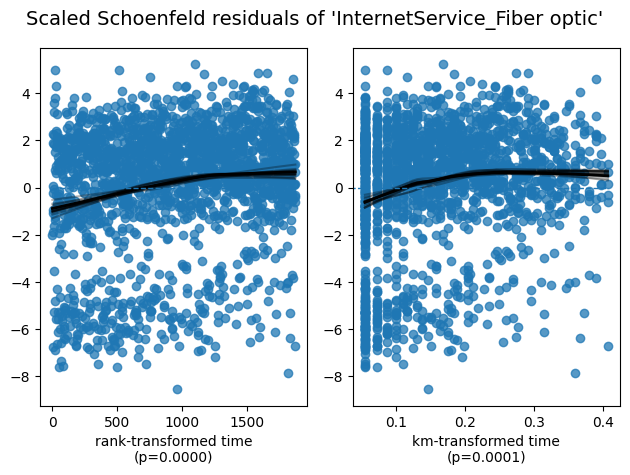

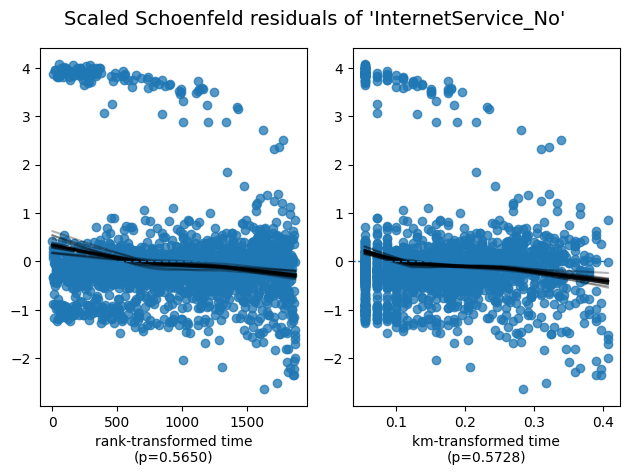

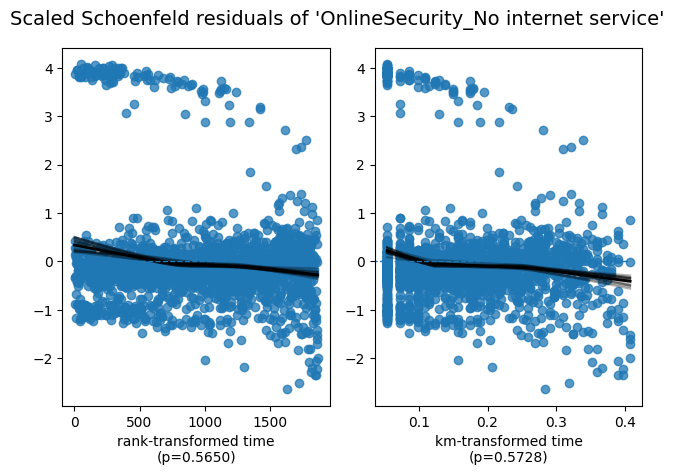

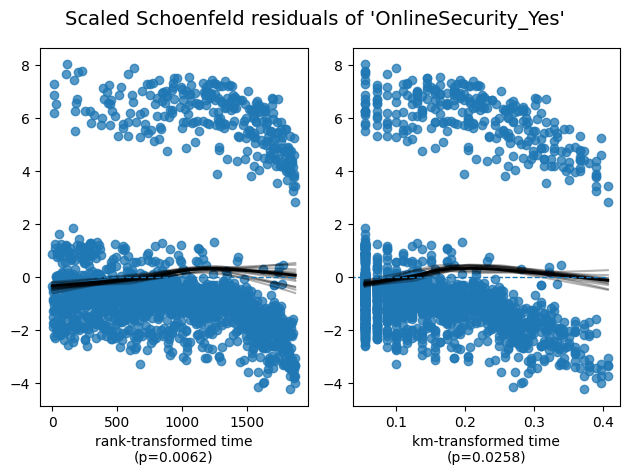

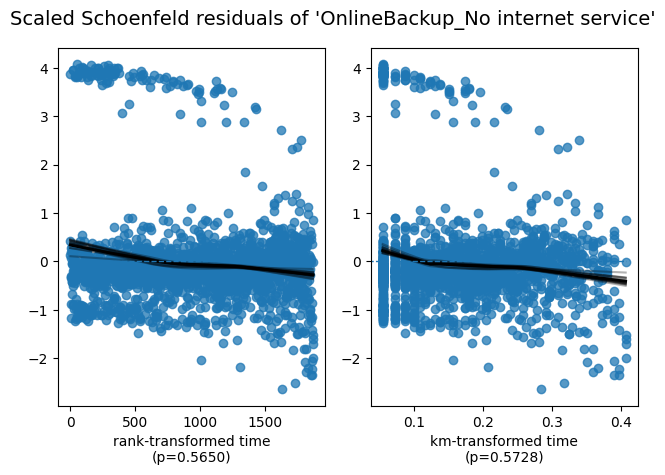

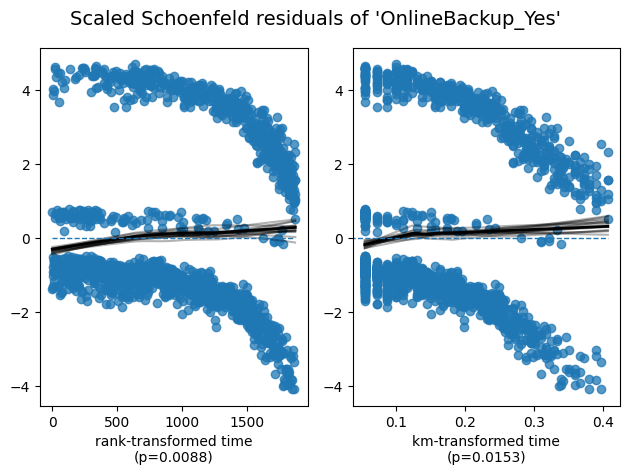

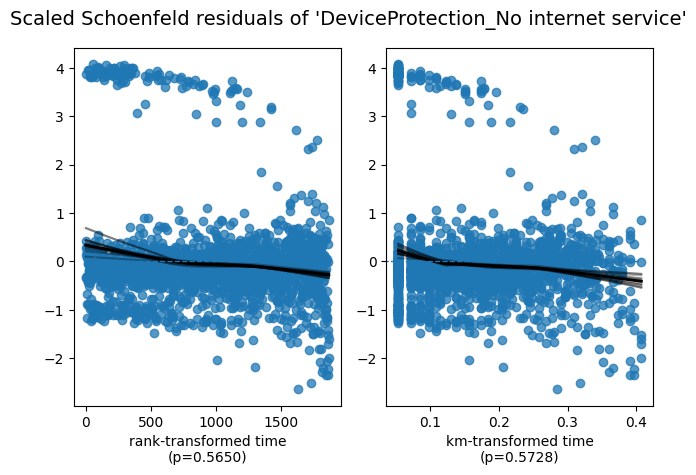

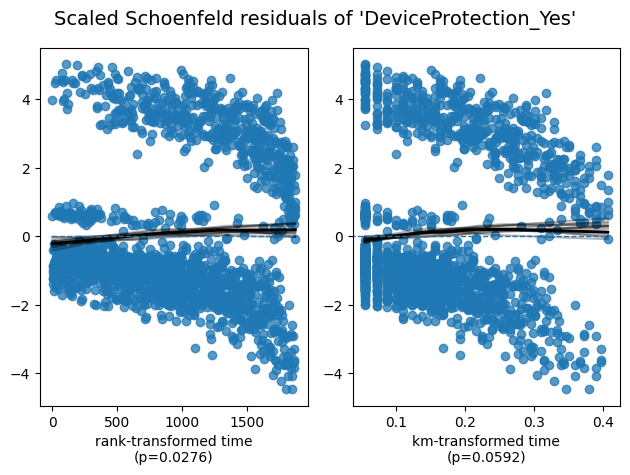

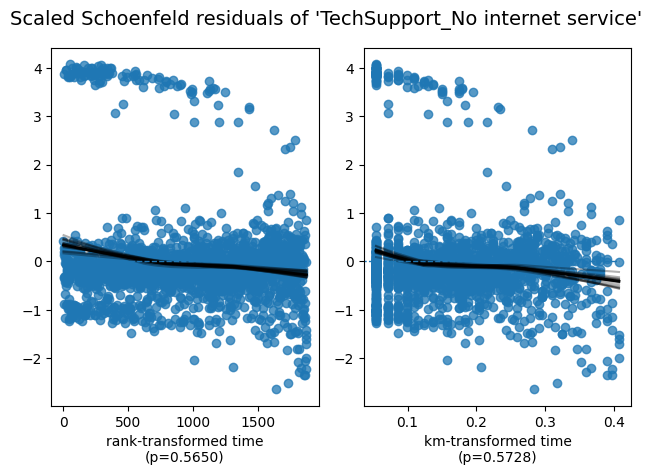

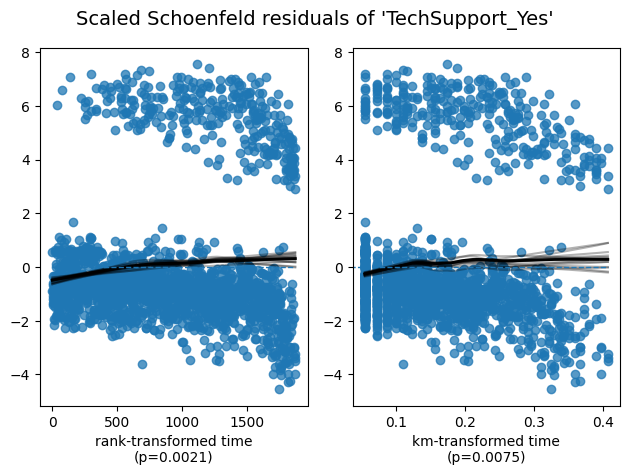

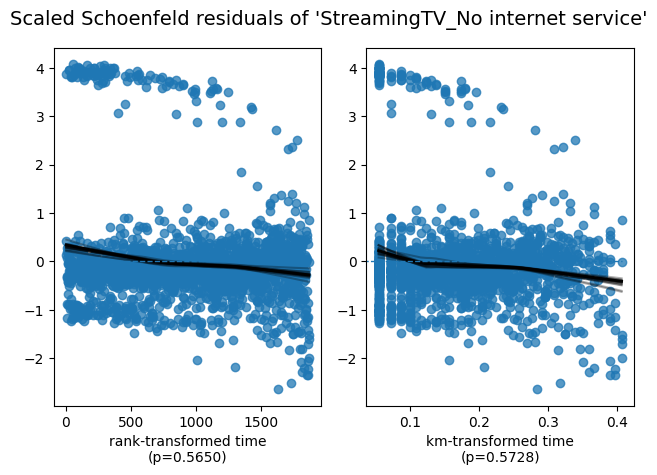

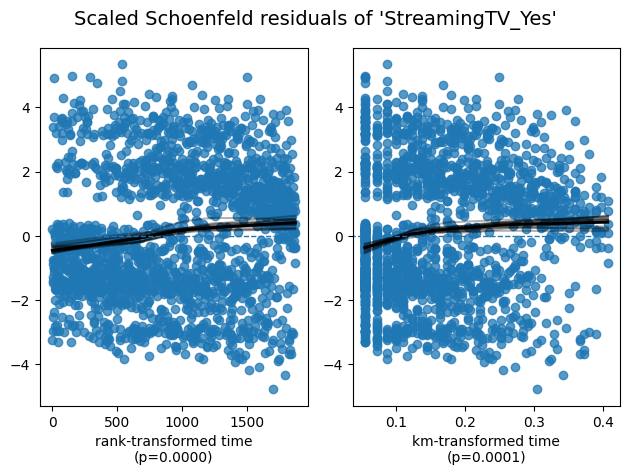

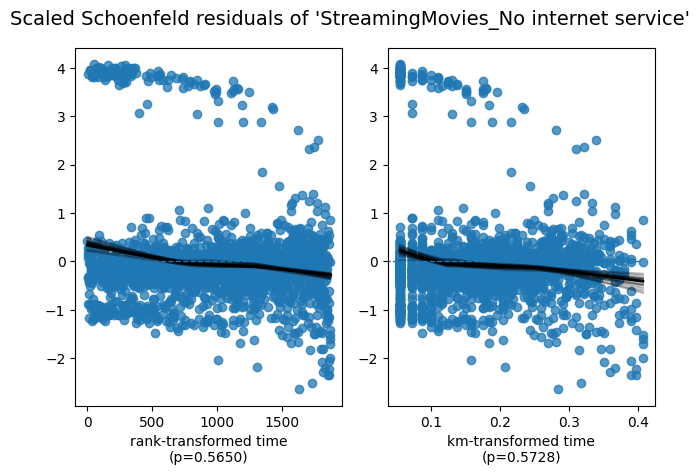

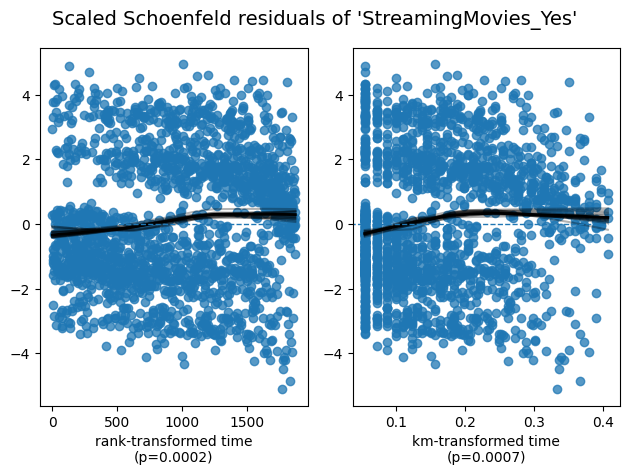

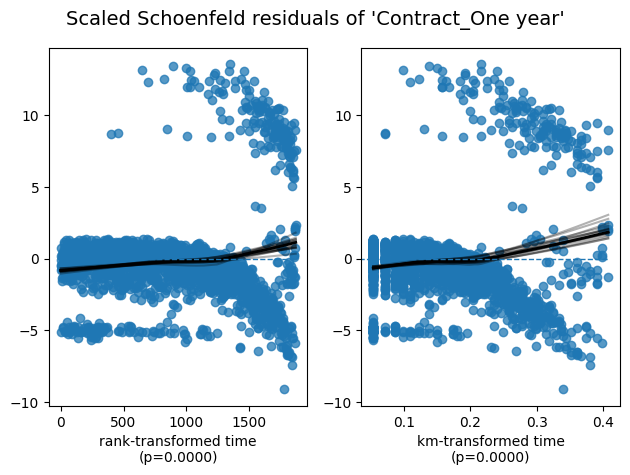

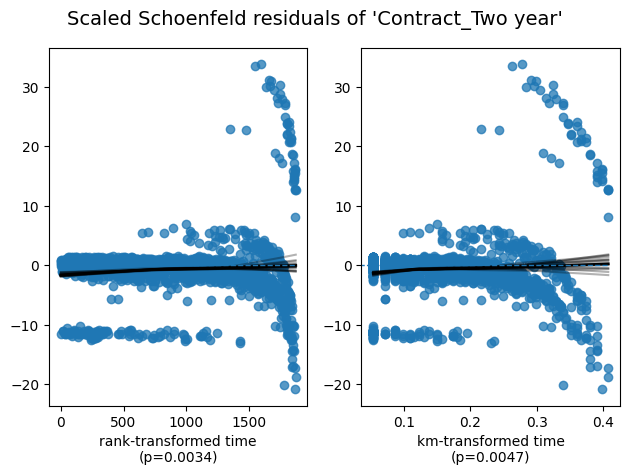

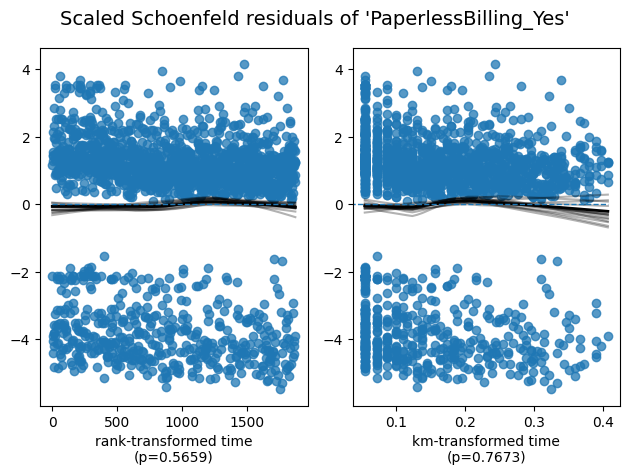

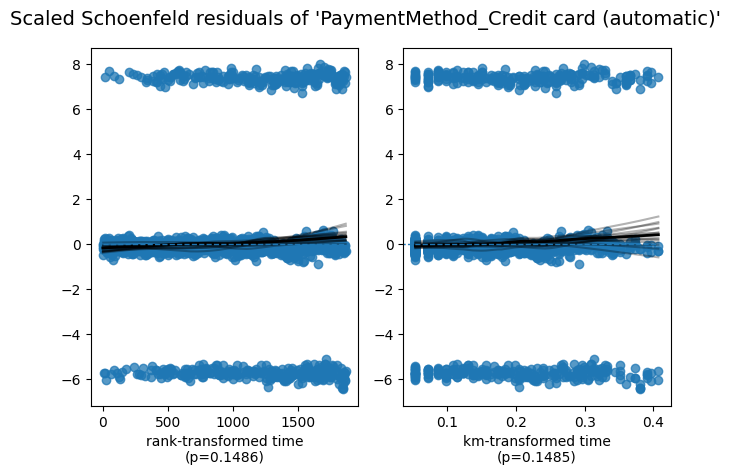

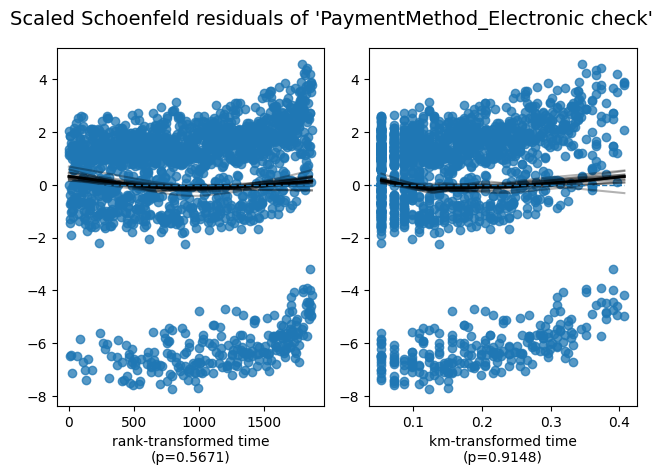

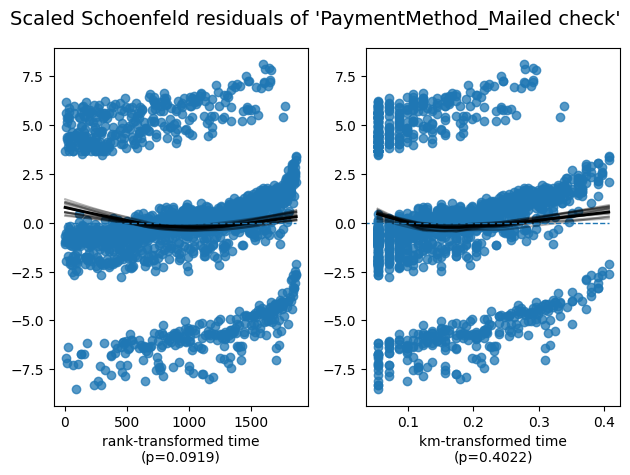

In [72]:
# This prints test results and can optionally show plots
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=True)


### Baseline survival curve from Cox model

<Figure size 700x500 with 0 Axes>

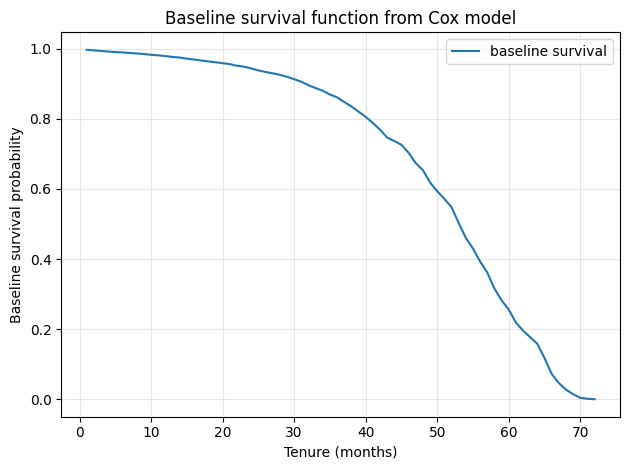

In [73]:
plt.figure(figsize=(7, 5))
cph.baseline_survival_.plot()
plt.title("Baseline survival function from Cox model")
plt.xlabel("Tenure (months)")
plt.ylabel("Baseline survival probability")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("baseline_survival_cox.png", dpi=300)  # choose name/format

plt.show()


### Cox model with L2 (ridge-like) penalisation

In [74]:
# Example L2 penalty (set l1_ratio=0 => pure ridge in lifelines)
cph_ridge = CoxPHFitter(penalizer=0.1, l1_ratio=0.0)
cph_ridge.fit(cox_df, duration_col=time_col, event_col="Churn_event")
cph_ridge.print_summary()


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -13927.38
         time fit was run = 2026-02-07 12:25:13 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                         0.09      1.09      0.03            0.02            0.15                1.02                1.17
TotalCharges                          -0.85      0.43      0.03           -0.91           -0.79                0.40                0.45
gender_Male                           -0.03      0.97      0.04           -0.11            0.04                0.89                1.04
SeniorCitizen_1                        0.05      1.05      0.05           -0.05            0.14                0.95                1.15
Partner_Yes                           -0.31      0.73      0.04           -0.39           -0.23                0.67                0.80
Dependents_Yes                        -0.15      0.86      0.05           -0.25           -0.05                0.78                0.95
PhoneService_Yes                       0.11      1.12      0.10           -0.08            0.31                0.92                1.36
MultipleLines_No phone service        -0.11      0.90      0.10           -0.31            0.08                0.74                1.09
MultipleLines_Yes                     -0.15      0.86      0.04           -0.24           -0.07                0.79                0.94
InternetService_Fiber optic            0.47      1.60      0.05            0.37            0.58                1.45                1.78
InternetService_No                    -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
OnlineSecurity_No internet service    -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
OnlineSecurity_Yes                    -0.43      0.65      0.05           -0.52           -0.33                0.59                0.72
OnlineBackup_No internet service      -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
OnlineBackup_Yes                      -0.31      0.73      0.04           -0.40           -0.23                0.67                0.80
DeviceProtection_No internet service  -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
DeviceProtection_Yes                  -0.18      0.83      0.05           -0.27           -0.09                0.76                0.91
TechSupport_No internet service       -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
TechSupport_Yes                       -0.34      0.71      0.05           -0.43           -0.24                0.65                0.79
StreamingTV_No internet service       -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
StreamingTV_Yes                        0.04      1.04      0.04           -0.05            0.12                0.95                1.13
StreamingMovies_No internet service   -0.22      0.80      0.09           -0.39           -0.06                0.68                0.95
StreamingMovies_Yes                    0.01      1.01      0.04           -0.08            0.10                0.92                1.10
Contract_One year                     -0.67      0.51      0.06           -0.78           -0.55                0.46                0.58
Contract_Two year            

### Cox model with L1 (lasso-like) penalisation

In [77]:
from lifelines import CoxPHFitter

# Lasso model: L1 penalty (l1_ratio=1.0)
cph_lasso = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
cph_lasso.fit(cox_df_reduced, duration_col=time_col, event_col="Churn_event")
cph_lasso.print_summary()

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_event'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -13206.19
         time fit was run = 2026-02-07 12:30:10 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                         0.83      2.29      0.22            0.40            1.26                1.49                3.51
TotalCharges                          -2.90      0.05      0.08           -3.06           -2.75                0.05                0.06
gender_Male                           -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
SeniorCitizen_1                        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Partner_Yes                           -0.16      0.85      0.05           -0.27           -0.06                0.76                0.95
Dependents_Yes                        -0.05      0.95      0.07           -0.18            0.08                0.83                1.08
PhoneService_Yes                       0.00      1.00      0.18           -0.36            0.36                0.70                1.44
MultipleLines_Yes                      0.00      1.00      0.00           -0.00            0.00                1.00                1.00
InternetService_Fiber optic            0.60      1.82      0.20            0.21            0.99                1.23                2.70
InternetService_No                    -1.22      0.30      0.23           -1.68           -0.76                0.19                0.47
OnlineSecurity_Yes                    -0.23      0.79      0.07           -0.37           -0.09                0.69                0.92
OnlineBackup_Yes                      -0.08      0.92      0.07           -0.21            0.04                0.81                1.04
DeviceProtection_Yes                  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
TechSupport_Yes                       -0.10      0.91      0.07           -0.24            0.05                0.79                1.05
StreamingTV_Yes                        0.02      1.02      0.09           -0.17            0.20                0.85                1.22
StreamingMovies_Yes                    0.01      1.01      0.09           -0.17            0.19                0.84                1.21
Contract_One year                     -1.01      0.36      0.09           -1.19           -0.83                0.30                0.44
Contract_Two year                     -2.83      0.06      0.16           -3.15           -2.50                0.04                0.08
PaperlessBilling_Yes                   0.11      1.11      0.06           -0.00            0.22                1.00                1.24
PaymentMethod_Credit card (automatic) -0.03      0.97      0.09           -0.20            0.14                0.82                1.15
PaymentMethod_Electronic check         0.31      1.36      0.07            0.17            0.44                1.18                1.56
PaymentMethod_Mailed check             0.25      1.29      0.09            0.08            0.42                1.09                1.52

                                       cmp to      z      p  -log2(p)
covariate                                                            
MonthlyCharges                           0.00   3.79 <0.005     12.72
TotalCharges                             0.00 -36.50 <0.005    966.35
gender_Male        

### Fit penalised models and compare coefficients

In [78]:
# 1) all covariates (no time, no event)
X = cox_df_penalty.drop(columns=[time_col, "Churn_event"])

# 2) drop constant columns
non_const_cols = [c for c in X.columns if X[c].nunique() > 1]
X_nc = X[non_const_cols]

# 3) drop one of any pair with correlation ~1
corr = X_nc.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.999)]

X_reduced = X_nc.drop(columns=to_drop)

cox_df_reduced = pd.concat(
    [cox_df_penalty[[time_col, "Churn_event"]], X_reduced],
    axis=1
)

cph = CoxPHFitter(penalizer=0.01)
cph.fit(cox_df_reduced, duration_col=time_col, event_col="Churn_event")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -13061.79
         time fit was run = 2026-02-07 12:30:15 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                         0.39      1.48      0.10            0.20            0.59                1.22                1.80
TotalCharges                          -2.38      0.09      0.06           -2.50           -2.26                0.08                0.10
gender_Male                           -0.04      0.96      0.05           -0.13            0.05                0.88                1.05
SeniorCitizen_1                        0.03      1.03      0.06           -0.08            0.13                0.92                1.14
Partner_Yes                           -0.24      0.79      0.05           -0.35           -0.14                0.71                0.87
Dependents_Yes                        -0.11      0.89      0.07           -0.24            0.02                0.78                1.02
PhoneService_Yes                       0.35      1.41      0.12            0.11            0.58                1.12                1.78
MultipleLines_Yes                     -0.04      0.96      0.05           -0.15            0.06                0.86                1.07
InternetService_Fiber optic            0.77      2.17      0.11            0.57            0.98                1.76                2.67
InternetService_No                    -1.56      0.21      0.14           -1.83           -1.28                0.16                0.28
OnlineSecurity_Yes                    -0.32      0.73      0.07           -0.45           -0.19                0.64                0.83
OnlineBackup_Yes                      -0.17      0.84      0.06           -0.28           -0.06                0.76                0.94
DeviceProtection_Yes                  -0.02      0.98      0.06           -0.13            0.09                0.88                1.10
TechSupport_Yes                       -0.19      0.82      0.07           -0.32           -0.06                0.73                0.94
StreamingTV_Yes                        0.16      1.18      0.06            0.04            0.28                1.04                1.33
StreamingMovies_Yes                    0.15      1.17      0.06            0.03            0.27                1.03                1.31
Contract_One year                     -1.07      0.34      0.09           -1.24           -0.90                0.29                0.41
Contract_Two year                     -2.60      0.07      0.14           -2.87           -2.33                0.06                0.10
PaperlessBilling_Yes                   0.18      1.19      0.06            0.07            0.29                1.07                1.33
PaymentMethod_Credit card (automatic) -0.07      0.93      0.08           -0.24            0.09                0.79                1.10
PaymentMethod_Electronic check         0.40      1.50      0.07            0.27            0.54                1.31                1.71
PaymentMethod_Mailed check             0.45      1.57      0.08            0.29            0.61                1.34                1.84

                                       cmp to      z      p  -log2(p)
covariate                                                            
MonthlyCharges                           0.00   3.90 <0.005     13.36
TotalCharges                             0.00 -38.39 <0.005       inf
gender_Male        

### Visualise shrinkage of coefficients and save figure

In [79]:
# Refit all three models using the cleaned data (cox_df_reduced) for comparison
# This data has collinear features removed
 
cph_standard = CoxPHFitter(penalizer=0.01)
cph_standard.fit(cox_df_reduced, duration_col=time_col, event_col="Churn_event")

cph_ridge_cmp = CoxPHFitter(penalizer=0.1, l1_ratio=0.0)
cph_ridge_cmp.fit(cox_df_reduced, duration_col=time_col, event_col="Churn_event")

cph_lasso_cmp = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
cph_lasso_cmp.fit(cox_df_reduced, duration_col=time_col, event_col="Churn_event")

# Create comparison dataframe from all three models
coef_standard = cph_standard.summary["coef"]
coef_ridge = cph_ridge_cmp.summary["coef"]
coef_lasso = cph_lasso_cmp.summary["coef"]

coef_compare = pd.DataFrame({
    "Standard": coef_standard,
    "Ridge": coef_ridge,
    "Lasso": coef_lasso
})

print(coef_compare.head(10))

                             Standard     Ridge         Lasso
covariate                                                    
MonthlyCharges               0.392115  0.174175  8.282550e-01
TotalCharges                -2.380693 -0.827632 -2.904587e+00
gender_Male                 -0.040816 -0.033086 -3.994314e-07
SeniorCitizen_1              0.025278  0.056557  1.777414e-06
Partner_Yes                 -0.241664 -0.319768 -1.619587e-01
Dependents_Yes              -0.113302 -0.169350 -5.163098e-02
PhoneService_Yes             0.345920  0.030138  2.788873e-03
MultipleLines_Yes           -0.040848 -0.157758  3.132963e-08
InternetService_Fiber optic  0.773115  0.523446  5.994940e-01
InternetService_No          -1.556700 -0.764321 -1.219750e+00


<Figure size 1000x600 with 0 Axes>

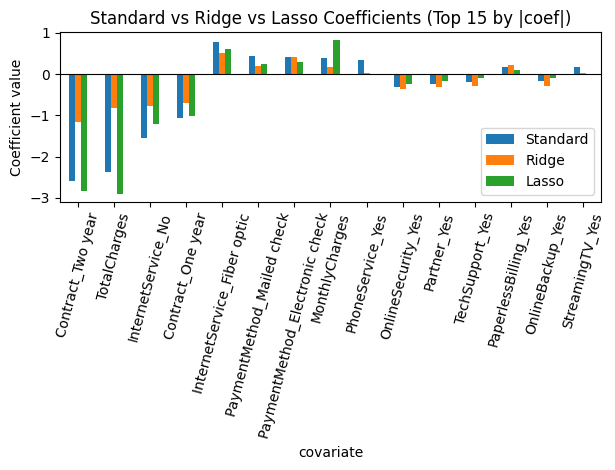

In [80]:
# Plot a few largest coefficients by absolute value in the standard model
top_features = coef_standard.abs().sort_values(ascending=False).head(15).index

plot_df = coef_compare.loc[top_features]

plt.figure(figsize=(10, 6))
plot_df.plot(kind="bar")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Standard vs Ridge vs Lasso Coefficients (Top 15 by |coef|)")
plt.ylabel("Coefficient value")
plt.xticks(rotation=75)
plt.tight_layout()

plt.savefig("cox_coefficients_shrinkage.png", dpi=300)
plt.show()


### 5-fold cross-validation for C-index (standard vs penalised)

In [89]:
from lifelines.utils import k_fold_cross_validation

# Models to evaluate (already fitted above, but CV will refit internally)
models_to_eval = {
    "Standard": CoxPHFitter(penalizer=0.01),
    "Ridge_0.1": CoxPHFitter(penalizer=0.1, l1_ratio=0.0),
    "Lasso_0.01": CoxPHFitter(penalizer=0.01, l1_ratio=1.0),
}

cv_results = {}

for name, model in models_to_eval.items():
    scores = k_fold_cross_validation(
        model,
        cox_df_reduced,
        duration_col=time_col,
        event_col="Churn_event",
        k=5,
        scoring_method="concordance_index",
    )
    cv_results[name] = scores
    print(
        f"{name} C-index scores:", np.round(scores, 3),
        " | mean:", np.round(np.mean(scores), 3)
    )

cv_results


Standard C-index scores: [0.924 0.93  0.926 0.921 0.919]  | mean: 0.924
Ridge_0.1 C-index scores: [0.908 0.9   0.901 0.907 0.898]  | mean: 0.903
Lasso_0.01 C-index scores: [0.919 0.938 0.942 0.923 0.917]  | mean: 0.928


{'Standard': [np.float64(0.9243324818102874),
  np.float64(0.9300970792929896),
  np.float64(0.9263485018488529),
  np.float64(0.9208160591617035),
  np.float64(0.9189160042342698)],
 'Ridge_0.1': [np.float64(0.9075969385056143),
  np.float64(0.8999328558015652),
  np.float64(0.9011861920761346),
  np.float64(0.906992755279276),
  np.float64(0.8984779702556676)],
 'Lasso_0.01': [np.float64(0.9190281242371269),
  np.float64(0.9375026477142107),
  np.float64(0.9418690315290364),
  np.float64(0.9225347293505782),
  np.float64(0.917144291218251)]}

### Visualise C-index distribution across models and save figure

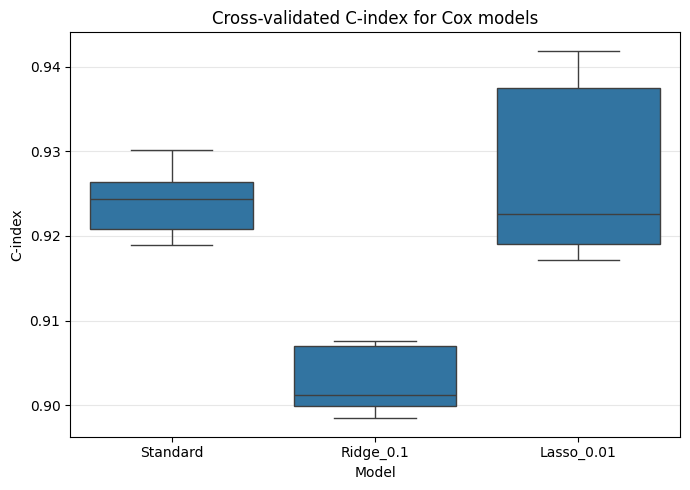

In [90]:
cv_df = []

for name, scores in cv_results.items():
    for s in scores:
        cv_df.append({"Model": name, "C-index": s})

cv_df = pd.DataFrame(cv_df)

plt.figure(figsize=(7, 5))
sns.boxplot(data=cv_df, x="Model", y="C-index")
plt.title("Cross-validated C-index for Cox models")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()

plt.savefig("cox_cv_cindex_boxplot.png", dpi=300)
plt.show()


### Predicted risk scores distribution and save figure

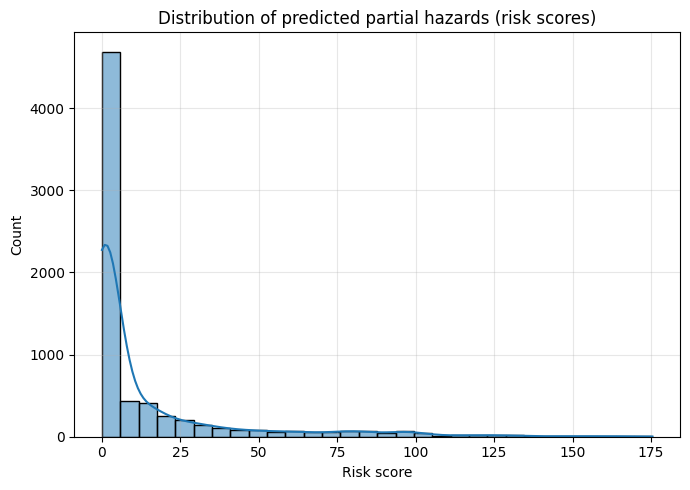

In [91]:
# Use the fitted standard Cox model
risk_scores = cph.predict_partial_hazard(cox_df_penalty)

plt.figure(figsize=(7, 5))
sns.histplot(risk_scores.values.flatten(), bins=30, kde=True)
plt.title("Distribution of predicted partial hazards (risk scores)")
plt.xlabel("Risk score")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig("cox_risk_scores_distribution.png", dpi=300)
plt.show()


### Simple interpretation summary (printed text)

In [92]:
print("Summary scaffold:")
print("- Kaplan–Meier curves show which contract/payment groups retain customers longer.")
print("- Global and pairwise log-rank tests indicate whether survival differences are statistically significant.")
print("- Cox PH model hazard ratios quantify how each feature changes churn hazard, holding others fixed.")
print("- Proportional hazards checks indicate which covariates may have time-varying effects.")
print("- Penalised Cox models (ridge/lasso) help stabilise estimates and may improve generalisation.")
print("- Cross-validated C-index compares predictive discrimination among models.")
print("- Coefficient and risk-score plots illustrate which variables are most influential for churn risk.")


Summary scaffold:
- Kaplan–Meier curves show which contract/payment groups retain customers longer.
- Global and pairwise log-rank tests indicate whether survival differences are statistically significant.
- Cox PH model hazard ratios quantify how each feature changes churn hazard, holding others fixed.
- Proportional hazards checks indicate which covariates may have time-varying effects.
- Penalised Cox models (ridge/lasso) help stabilise estimates and may improve generalisation.
- Cross-validated C-index compares predictive discrimination among models.
- Coefficient and risk-score plots illustrate which variables are most influential for churn risk.
